In [1]:
import numpy as np
import networkx as nx
import pandas as pd
import pickle
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import normalize
from sklearn.preprocessing import minmax_scale
from scipy.stats import spearmanr
from si_animator import plot_network_usa
%matplotlib inline

Let's first take a look at what we've got in the data

In [2]:
traffic_events = pd.read_csv('events_US_air_traffic_GMT.txt', sep=' ')
traffic_events.head()

,Source,Destination,StartTime,EndTime,Duration
0,0,1,1229286900,1229291520,4620
1,0,1,1229272800,1229277300,4500
2,0,2,1229285640,1229291520,5880
3,0,3,1229268060,1229276040,7980
4,0,3,1229284740,1229293140,8400


## Task 1: Basic implementation

Implement the SI model using the temporal air traffic data. Use the provided visualization
module to check that your implementation works reasonably. Assume first that $p = 1$, i.e., the
disease is always transmitted.

### a) If Allentown (node-id=0) is infected at the beginning of the data set, at which time does Anchorage (ANC, node-id=41) become infected?
Hint: The time point should fall within the range 
`1229290000-1229291000`

In [3]:
# Now let's load the data in a nicer way
def load_events():
    traffic_events = pd.read_csv('events_US_air_traffic_GMT.txt', sep=' ')
    traffic_events = traffic_events.sort_values(by=['StartTime', 'EndTime'], ascending=[True, True])
    traffic_events['Source'] = traffic_events['Source'].astype(str)
    traffic_events['Destination'] = traffic_events['Destination'].astype(str)
    traffic_events = traffic_events.reset_index(drop=True)
    return traffic_events

In [4]:
traffic_events = load_events()
traffic_events.head()

,Source,Destination,StartTime,EndTime,Duration
0,27,49,1229231100,1229246760,15660
1,30,2,1229233200,1229245980,12780
2,251,20,1229235000,1229246340,11340
3,12,4,1229235300,1229244960,9660
4,180,20,1229235300,1229245500,10200


In [5]:
print('Allentown will be infected at: '+ str(min(traffic_events['StartTime'])))

Allentown will be infected at: 1229231100


In [6]:
def network_initialization(seed_nodes='0'):
    net = nx.read_weighted_edgelist('./aggregated_US_air_traffic_network_undir.edg')
    
    infection_times = {node: float('inf') for node in net.nodes()}
    nx.set_node_attributes(net, infection_times, 'infection_time')
    
    if type(seed_nodes) == str:
        # make sure the node exists in the network
        assert net.has_node(seed_nodes)
        net.nodes[seed_nodes]['infection_time'] = min(traffic_events['StartTime'])
        
    elif type(seed_nodes) in [list, np.ndarray]:
        # make sure the node exists in the network
        for node in seed_nodes:
            assert net.has_node(node)
        for node in seed_nodes:
            net.nodes[node]['infection_time'] = min(traffic_events['StartTime'])
            
    return net

In [7]:
# Let's see if the initialization is correct
net = network_initialization()
print('Allentown will be infected at: '+ str(net.nodes['0']))

Allentown will be infected at: {'infection_time': 1229231100}


In [8]:
def simulate_infection(p=0.5, seed_nodes='0'):
    traffic_events = load_events()
    net = network_initialization(seed_nodes)
    
    for i in range(traffic_events.shape[0]):
        row = traffic_events.iloc[i]
        source, destination, start, end, duration = tuple(row)
        if (start >= net.nodes[source]['infection_time']) and (np.random.rand() <= p) and (end < net.nodes[destination]['infection_time']):
            net.nodes[destination]['infection_time'] = end
            
    return net

Finally, let's see when will Node 41 be infected 

In [9]:
net = simulate_infection(p=1)
node = '41'
print('Node 41 is infected at time:' + str(net.nodes['41']['infection_time']))

Node 41 is infected at time:1229290800


## Task 2: Effect of infection probability $p$ on spreading speed

Run the SI-model 10 times with each of the infection probabilities [0.01, 0.05, 0.1, 0.5, 1.0].
Again, let Allentown (node-id=0) be the initially infected node. Record all infection times of
the nodes, and answer the following questions:

### a) Plot the averaged prevalence $\rho(t)$ of the disease (fraction of infected nodes) as a function of time for each of the infection probabilities. Plot the 5 curves in one graph.


In [10]:
def calc_prevalence(net, steps=30):
    prevalence = []
    timesteps = np.linspace(min(traffic_events['StartTime']), max(traffic_events['EndTime']), steps)
    for step in timesteps:
        n_infected = 0
        for node in net.nodes:
            if net.nodes[node]['infection_time'] <= step:
                n_infected += 1
        n_infected /= len(net.nodes) #normalization
        prevalence.append(n_infected)
    return prevalence

Now let's run the experiment and plot the results

In [11]:
ps = [0.01, 0.05, 0.1, 0.5, 1.0]
avg_prevalences = {}

for p in ps:
    print("Calc. for p = %s" % p)
    prevalences = []
    for _ in range(10):
        net = simulate_infection(p)
        prevalence = calc_prevalence(net)
        prevalences.append(prevalence)
        
    avg_prevalences[p] = [np.mean(prevalence) for prevalence in zip(*prevalences)]

Calc. for p = 0.01
Calc. for p = 0.05
Calc. for p = 0.1
Calc. for p = 0.5
Calc. for p = 1.0


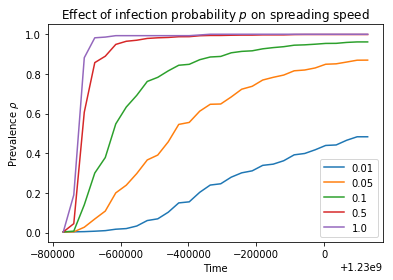

In [12]:
steps = 30
timesteps = np.linspace(min(traffic_events['StartTime']), max(traffic_events['EndTime']), steps)

fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_xlabel('Time')
ax.set_ylabel(r'Prevalence $\rho$')
ax.set_title(r"Effect of infection probability $p$ on spreading speed")
for p, prevalences in avg_prevalences.items():
    plt.plot(list(timesteps), prevalences, label=p)
    ax.legend()

plt.show()

### b) For which infection probabilities does the whole network become fully infected? What are the stepwise, nearly periodic “steps” in the curves due to?

Interestingly, only when p=1 will the whole network become fully infected. These nearly periodic steps may be due to the infection of a hub. If a hub is being infected, then the spreading speed would be higher, because typically a hub has more neighbors. 

## Task 3: Effect of seed node selection on spreading speed

Next, we will investigate how the selection of the seed node affects the spreading speed.

### a) Use nodes with node-ids [0, 4, 41, 100, 200] (ABE, ATL, ACN, HSV, DBQ) as seeds and p = 0.1, and run the simulation 10 times for each seed node. Then, plot the average prevalence of the disease separately for each seed node as a function of time.

In [13]:
# same as the code chunk 10, the only difference is the seed nodes
p = 0.1
seeds = ['0', '4', '41', '100', '200']
avg_prevalences = {}

for seed_node in seeds:
    prevalences = []
    for _ in range(10):
        net = simulate_infection(p, seed_node)
        prevalence = calc_prevalence(net)
        prevalences.append(prevalence)

    avg_prevalences[seed_node] = [np.mean(prevalence) for prevalence in zip(*prevalences)]

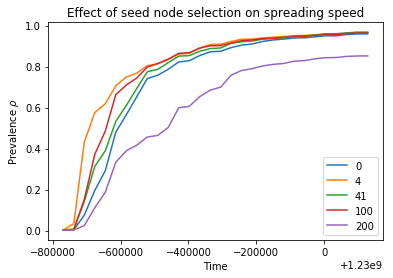

In [14]:
steps = 30
timesteps = np.linspace(min(traffic_events['StartTime']), max(traffic_events['EndTime']), steps)

fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_xlabel('Time')
ax.set_ylabel(r'Prevalence $\rho$')
ax.set_title(r"Effect of seed node selection on spreading speed")
for p, prevalences in avg_prevalences.items():
    plt.plot(list(timesteps), prevalences, label=p)
    ax.legend()

plt.show()

### b) You should be able to see differences in these spreading speed. Are these differences visible in the beginning of the epidemic or only later on? Why?

These differences are both visible in the beginning of the epidemic and later on. And actually they are more clear in the beginning since later on in all cases except for the case of using node 200 as seed node the prevalences all converge to somewhere around 0.95. A potential explanation is that seed nodes are located in component that have different connectivity measures, so in the beginning the spreading speeds will be quite different according to local vulnerablity, but later on as the infection spreads to well-connected components, the spreading speeds would be similar.

### c) In the next tasks, we will, amongst other things, inspect the vulnerability of a node for becoming infected with respect to various network centrality measures. Why is it important to average the results over different seed nodes?

As we see in b), selection of different seed nodes can affect a lot the spreading speed,it's reasonable to average their effects and reduce the variance. Also in the sense to control the variates that we are not interested in, it's important to average the results over different seed node.


## Task 4: Where to hide?

Now, consider you want to be as safe from the epidemic as possible. How should you select
your refuge? To answer this question, run your SI-model 50 times with $p = 0.5$ using different
random nodes as seeds and record the median infection times of each node. 

Note that the median infection time is not well defined for nodes that become infected in less than 25 runs.
You may leave those nodes out from your analyses.

### a) Run the 50 simulations, and create scatter plots showing the median infection time of each node as a function of the following nodal network measures:
i) unweighted clustering coefficient c    
ii) degree k    
iii) strength s    
iv) unweighted betweenness centrality    

We run 50 simulations with random seed node from 0 to 279 

In [15]:
# First we get the infection time 
infection_times = {}
p = 0.5
for _ in range(50):
    if _ % 5==0:
        print('iter: %s' % _)
    seed_node = str(np.random.randint(0,279))
    net = simulate_infection(p, seed_node)
    times = nx.get_node_attributes(net, 'infection_time')
    for node, time in times.items():
        if node not in infection_times.keys():
            infection_times[node] = []
            infection_times[node].append(time)
        else:
            infection_times[node].append(time)

iter: 0
iter: 5
iter: 10
iter: 15
iter: 20
iter: 25
iter: 30
iter: 35
iter: 40
iter: 45


In [16]:
# Then calculate the median infection time for each node 
median_infection_times = {node: 
np.median([time for time in times]) for node, times in infection_times.items()
}

In [17]:
# Now define the network measures we are interested in 
net_info = {
    'unweighted clustering coefficient': nx.clustering(net),
    'degree': dict(net.degree),
    'strength': net.degree(weight='weight'),
    'unweighted betweenness centrality': nx.betweenness_centrality(net),
}

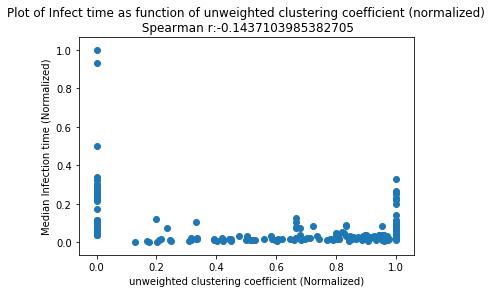

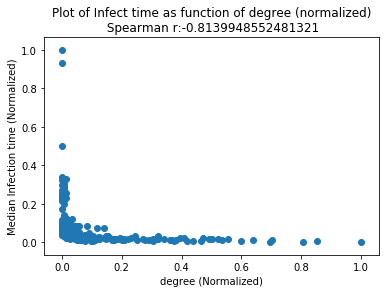

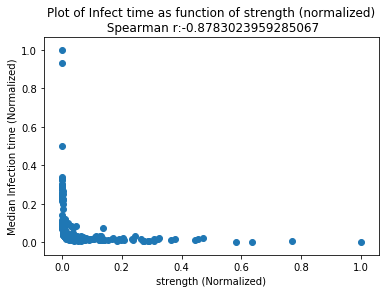

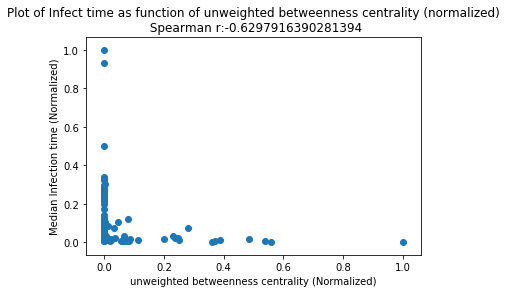

In [18]:
rs = []
for i, (title, info) in enumerate(net_info.items()):
    x=[]
    y=[]
    for node in list(net.nodes):
        x.append(info[node])
        y.append(median_infection_times[node])
    rho = spearmanr(x, y).correlation
    rs.append((title, rho))
    x, y = minmax_scale(x), minmax_scale(y)
    fig = plt.figure()
    ax = fig.add_subplot(111)
    plt.xlabel(f'{title} (Normalized)')
    plt.ylabel('Median Infection time (Normalized)')
    plt.scatter(x, y)
    plt.title(f'Plot of Infect time as function of {title} (normalized)\n Spearman r:{rho}')
    plt.show()

### b)  Use the Spearman rank-correlation coefficient for finding out, which of the measures is the best predictor for the infection times

In [19]:
print('Spearman rank-correlation coefficient for')
for measure, rho in rs:
    print(f'{measure}: {rho}')

Spearman rank-correlation coefficient for
unweighted clustering coefficient: -0.1437103985382705
degree: -0.8139948552481321
strength: -0.8783023959285067
unweighted betweenness centrality: -0.6297916390281394


strength (rho: -0.887) and degree k (rho: -0.817) seems to be better predictors for infection times

### c)  Discuss your results for each network centrality metric. Especially, explain the ranking of the network measures as measured by the median infection time.

## Task 5: Shutting down airports

Now, take the role of a government official considering shutting down airports to prevent the
disease from spreading to the whole country. In our simulations, the shutting down of airports
corresponds to immunization: an airport that has been shut down can not become infected at
any point of the simulation.

One immunization strategy suggested for use in social networks is to 
- pick a random node from the network and immunize one of this focal node’s neighbors. 

Your task is now to compare this strategy against seven other immunization strategies: 
- the immunization of random nodes and
- the immunization of nodes that possess the largest values of the six nodal network measures we used in task 4. 
In this exercise, use $p = 0.5$ and average your results over 20 runs of the model
for each immunization strategy (160 simulations in total).

To reduce the variance due to the selection of seed nodes, use same seed nodes when investigating
each immunization strategy: first select your immunized nodes, and then select 20 random seed
nodes such that none of them belongs to the group of immunized nodes in any of the 8 different
strategies.

Here are the 8 different strategies we are going to compare:

    1. random neighbour   
    2. random immune nodes  
    3. highest k-shell   
    4. highest unweighted clustering coefficient c  
    5. highest degree k 
    6. highest strength s   
    7. highest unweighted betweenness centrality   
    8. highest closeness centrality     
    

First we initiate immune nodes for all 8 strategies

In [20]:
net_info = {
    'k-shell': nx.core_number(net),
    'unweighted clustering coefficient': nx.clustering(net),
    'degree': dict(net.degree),
    'strength': net.degree(weight='weight'),
    'unweighted betweenness centrality': nx.betweenness_centrality(net),
    'closeness centrality': nx.closeness_centrality(net)
}

In [21]:
nodes = list(net.node)
num_immune_nodes = 10
immune_nodes = {}
immune_nodes["random immunization"] = np.random.choice(nodes, num_immune_nodes)
immune_nodes["random_neighbour"] = []
for i in range(num_immune_nodes):
    sampled_node = np.random.choice(nodes)
    sampled_node_neighbor = np.random.choice(list(net.neighbors(sampled_node)))
    immune_nodes["random_neighbour"].append(sampled_node_neighbor)
immune_nodes["random_neighbour"] = np.array(immune_nodes["random_neighbour"])
for measure in list(net_info.keys()):
    d = dict(net_info[measure])
    selected_nodes = sorted(d.keys(),key=lambda key: d[key], reverse=True)[:num_immune_nodes]
    immune_nodes[measure] = np.array(selected_nodes)

In [22]:
# Then select 20 seed nodes for our 20 runs

all_immune_nodes = set(np.array([node for measure,node in immune_nodes.items()]).flatten())

seed_nodes = []
while len(seed_nodes)<20:
    node = np.random.choice(nodes)
    if node not in all_immune_nodes:
        seed_nodes.append(node)

### a)  Adapt your code to enable immunization of nodes, and plot the prevalence of the disease as a function of time for the 8 different immunization strategies (social net., random node, and 6 nodal network measures) when 10 nodes are always immunized

In [23]:
def simulate_infection_with_immune(p=1, seed_nodes='0', immune_nodes=None):
    traffic_events = load_events()
    net = network_initialization(seed_nodes)
    
    for i in range(traffic_events.shape[0]):
        row = traffic_events.iloc[i]
        source, destination, start, end, duration = tuple(row)
        if source in immune_nodes or destination in immune_nodes:
            continue
        elif (start >= net.nodes[source]['infection_time']) and (np.random.rand() <= p) and (end < net.nodes[destination]['infection_time']):
            net.nodes[destination]['infection_time'] = end 
    return net

In [24]:
# now finally we can run our experiements 
p = 0.5
infection_times_strategies = {}

for key in immune_nodes.keys():
    print(f"Calc for strategy: {key}")
    nodes = immune_nodes[key]
    
    infection_times = {}
    
    for _ in range(20):
        if _%5==0:
            print(f"{_}/{20}")
        net = simulate_infection_with_immune(p=p, seed_nodes=seed_nodes, immune_nodes=nodes)
        
        times = nx.get_node_attributes(net, 'infection_time')
        
        # store results
        for node, time in times.items():
            if node not in infection_times.keys():
                infection_times[node] = []
                infection_times[node].append(time)
            else:
                infection_times[node].append(time)
                
    infection_times_strategies[key] = infection_times
    print(f"Completed: {key}")

Calc for strategy: random immunization
0/20
5/20
10/20
15/20
Completed: random immunization
Calc for strategy: random_neighbour
0/20
5/20
10/20
15/20
Completed: random_neighbour
Calc for strategy: k-shell
0/20
5/20
10/20
15/20
Completed: k-shell
Calc for strategy: unweighted clustering coefficient
0/20
5/20
10/20
15/20
Completed: unweighted clustering coefficient
Calc for strategy: degree
0/20
5/20
10/20
15/20
Completed: degree
Calc for strategy: strength
0/20
5/20
10/20
15/20
Completed: strength
Calc for strategy: unweighted betweenness centrality
0/20
5/20
10/20
15/20
Completed: unweighted betweenness centrality
Calc for strategy: closeness centrality
0/20
5/20
10/20
15/20
Completed: closeness centrality


In [25]:
# calculate median infection time and then prevalence
steps = 30
median_infection_times_strategy = {}
timesteps = np.linspace(min(traffic_events['StartTime']), max(traffic_events['EndTime']), steps)
prevalences = {}
for strategy, store_infection_times in infection_times_strategies.items():
    median_infection_times_strategy[strategy] = {}
    for node, infection_times in store_infection_times.items():
        median_infection_times_strategy[strategy][node] = np.median([time for time in infection_times])

for strategy, infected_dic in median_infection_times_strategy.items():
    prevalence = []
    for step in timesteps:
        n_infected = 0
        for node, infection_time in infected_dic.items():
            if infection_time <= step:
                n_infected += 1
        n_infected /= len(net.nodes) #normalization
        prevalence.append(n_infected)     
    prevalences[strategy] = prevalence

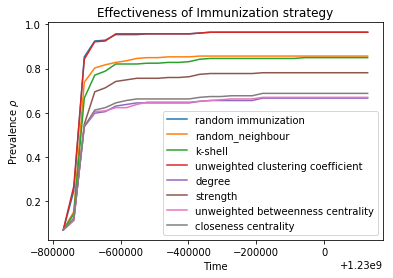

In [26]:
# plot the results
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_xlabel('Time')
ax.set_ylabel(r'Prevalence $\rho$')
ax.set_title("Effectiveness of Immunization strategy")
for strategy, prevalence in prevalences.items():
    ax.plot(list(timesteps), prevalence, label=strategy)
    ax.legend()

In [27]:
# recalculate rs according to our new measures
rs = []
for i, (title, info) in enumerate(net_info.items()):
    x=[]
    y=[]
    for node in list(net.nodes):
        x.append(info[node])
        y.append(median_infection_times[node])
    rho = spearmanr(x, y).correlation
    rs.append((title, rho))

In [28]:
# to discuss the ranking of the immunization strategies
# we would like to compare rho with prevalence for each strategy
final_prevalence = [(strategy, round(max(prevalence),3)) for strategy, prevalence in prevalences.items()]
sorted_final_prevalence = sorted(final_prevalence, key=lambda x: x[1])
sorted_rs = sorted([(measure,round(rho,3)) for measure, rho in rs], key=lambda x: x[1])

In [52]:
print("Infection ratio for")
sorted_final_prevalence

Infection ratio for


[('degree', 0.667),
 ('unweighted betweenness centrality', 0.67),
 ('closeness centrality', 0.688),
 ('strength', 0.781),
 ('k-shell', 0.849),
 ('random_neighbour', 0.857),
 ('random immunization', 0.964),
 ('unweighted clustering coefficient', 0.964)]

In [53]:
print('Spearman rank-correlation coefficient for')
sorted_rs

Spearman rank-correlation coefficient for


[('strength', -0.878),
 ('closeness centrality', -0.852),
 ('k-shell', -0.825),
 ('degree', -0.814),
 ('unweighted betweenness centrality', -0.63),
 ('unweighted clustering coefficient', -0.144)]

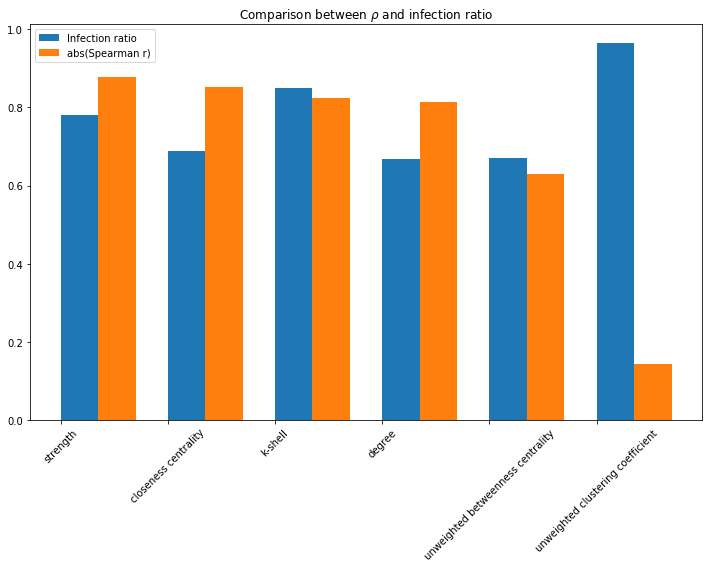

In [55]:
# then plot the results
n_groups = 6
 
# create plot
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111)
index = np.arange(n_groups)
bar_width = 0.35

val1 = [dict(sorted_final_prevalence)[i] for i,j in sorted_rs]
val2 = [-j for i,j in sorted_rs]

rects1 = plt.bar(index, val1, bar_width,
                 label='Infection ratio')
 
rects2 = plt.bar(index + bar_width, val2, bar_width,
                 label='abs(Spearman r)')
 
plt.title(r'Comparison between $\rho$ and infection ratio')
plt.xticks(index-bar_width/2, 
           [i for i,j in sorted_rs], rotation='45')
plt.legend()

fig.tight_layout()

plt.show()

## Task 6: Disease transmitting link

So far we have only analyzed the importance of network nodes—next, we will discuss the role of
links. We will do this by recording the number of times that each link transmits the disease to
another node. So adapt your code to recording the (undirected) static links which are used to
transmit the disease. You can do this by storing for each node from which other node it obtained
the infection, or alternatively, by using a dictionary where the keys are tuples corresponding to
a link, airport_a,airport_b with id’s ordered so that a<b, or by using a list of links, and
the values are incremented whenever the infection passes through the link. Run 20 simulations
using random nodes as seeds and p = 0:5. For each simulation, record which links are used to
infect yet uninfected airports (either susceptible airports or the infecting flight arrives before the
already recorded infection time).

In [30]:
# here we adapt our code of infection simulation to create an additional dictionary
# to store the link spread records
def simulate_infection_with_immune2(p=1, seed_nodes='0', immune_nodes=None):
    traffic_events = load_events()
    net = network_initialization(seed_nodes)
    edge_infection_transmission = {}
    for i in range(traffic_events.shape[0]):
        row = traffic_events.iloc[i]
        source, destination, start, end, duration = tuple(row)
        if source in immune_nodes or destination in immune_nodes:
            continue
        elif (start >= net.nodes[source]['infection_time']) and (np.random.rand() <= p) and (end < net.nodes[destination]['infection_time']):
            net.nodes[destination]['infection_time'] = end 
            if int(source) < int(destination):
                if source+'-'+destination not in edge_infection_transmission.keys():
                    edge_infection_transmission[source+'-'+destination] = 1
                else:
                    edge_infection_transmission[source+'-'+destination] += 1
            else:
                if destination+'-'+source not in edge_infection_transmission.keys():
                    edge_infection_transmission[destination+'-'+source] = 1
                else:
                    edge_infection_transmission[destination+'-'+source] += 1
    return net, edge_infection_transmission

### a) (4 pts) Run the simulations, and compute the fraction of times that each link is used for infecting the disease (fij). Then use the provided function plot_network_USA which can be found in si_animator.py to visualize the network on top of the US map (see the example code given in the function). Adjust the width of the links according to the fractions fij to better see the overall structure. Compare your visualization with the maximal spanning tree of the network.

In [31]:
p = 0.5
seed_nodes = np.random.choice(nodes, 20)
transmission_count = {edge: 0 for edge in net.edges}
for i, seed in enumerate(seed_nodes):
    if i%5==0:
        print(f'{i}/{len(seed_nodes)}')
        
    net, edge_infection_transmission  = simulate_infection_with_immune2(p, seed_nodes=str(seed), immune_nodes=[])
    for edge, count in edge_infection_transmission.items():
        nodes = edge.split("-")
        if (nodes[0],nodes[1]) in transmission_count.keys():
            transmission_count[(nodes[0],nodes[1])] += count
        else:
            transmission_count[(nodes[1],nodes[0])] += count

0/20
5/20
10/20
15/20


In [42]:
edges = list(net.edges)
widths = []
for edge in edges:
    widths.append(transmission_count[edge]/20)

In [37]:
airport = pd.read_csv('US_airport_id_info.csv')
airport.head()
xycoords = {str(airport.id[index]):
 (airport.xcoordviz[index],airport.ycoordviz[index])
 for index in airport.index}

Text(0.5, 1.0, 'Transmission Links')

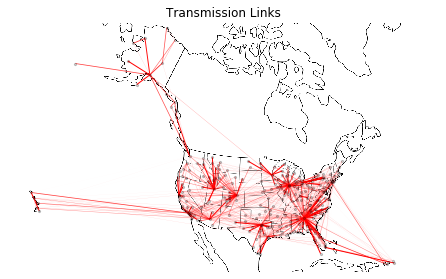

In [56]:
plot_network_usa(net, xycoords, edges=edges, linewidths=widths)
plt.title("Transmission Links")

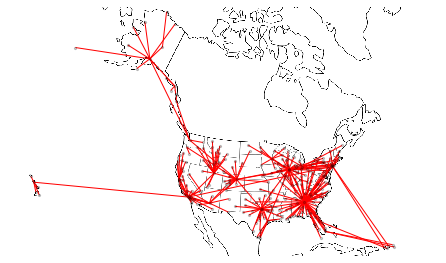

In [44]:
mst = nx.maximum_spanning_tree(net)
mst_edges = list(mst.edges)
plot_network_usa(mst, xycoords, 
                 mst_edges, [1 for _ in mst_edges])

### b)What do you notice? How would you explain your finding?

We can notice that our plot and the maximal spanning tree are quite similar. A reasonable explanation is that in maximal spanning tree edges with large weights are selected, and because edges with larger weights are used more than the others, which leads to high probability to spread the infection for more times. And this is exactly what we are trying to calculate and plot using our simulation.  

### c) Create scatter plots showing $f_{ij}$ as a function of the following link properties:

i) link weight $w_{ij}$

iii) _unweighted_ link betweenness centrality $eb_{ij}$

Compute also the Spearman correlation coefficients between fij and the two link-wise
measures.

In [45]:
edges = list(net.edges())

edge_info = {
    'weight': nx.get_edge_attributes(net, 'weight'),
    'link betweenness centrality' : nx.edge_betweenness_centrality(net)
}

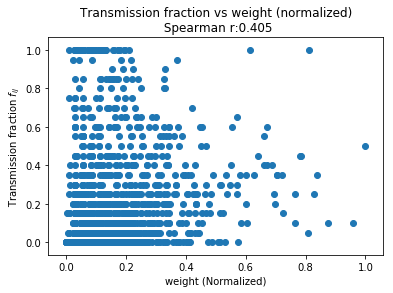

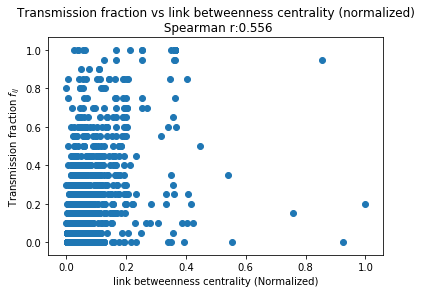

In [46]:
rs_edges = []

for measure, info in edge_info.items():
    x=[]
    y=[]
    for edge in edges:
        x.append(info[edge])
    x = minmax_scale(x)
    y = widths
    rho = spearmanr(x, y).correlation
    rs_edges.append((measure, rho))
    
    fig = plt.figure()
    ax = fig.add_subplot(111)
    plt.xlabel(f'{measure} (Normalized)')
    plt.ylabel(r'Transmission fraction $f_{ij}$')
    plt.scatter(x, y)
    plt.title(f'Transmission fraction vs {measure} (normalized)\n Spearman r:{round(rho,3)}')
    
    plt.show()

In [48]:
rs_edges

[('weight', 0.4054752528698251),
 ('link betweenness centrality', 0.5563146037032359)]

### d)  Explain the performance of the two link properties for predicting $f_{ij}$ 

Both 2 measures are not good enough in predicting  $f_{ij}$. Link betweenness has relatively better performance because it is the sum of the fraction of shortest paths that pass through the node considering all pairs of nodes. 